In [7]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

from ase import Atoms
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.cluster.cubic import FaceCenteredCubic
from ase.build import surface, bulk

from abtem.potentials import Potential
from abtem.waves import PlaneWave

# Build System

In [2]:
sampling = 0.05
resolution = 1200
L = resolution*sampling # Cell size

In [3]:
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [2, 2, 2]

atoms = FaceCenteredCubic('Au', surfaces, layers)
# atoms.rotate(v='y', a=45.0, center='COU')
atoms.rotate((1, 1, 1), (1, 0, 0))
atoms.rotate((0, -1, 1), (0, 0, -1))

system = Atoms(atoms)
system.set_cell((L,L,L))
system.center()

In [4]:
limit = 2.0
# Cut out atoms outside the cell
pos = system.positions
keep = np.ones(len(system),bool)
for j, p in enumerate(pos):
    if (p[0]>L-limit or p[1]>L-limit or p[2]>L-limit):
        keep[j] *= False
    elif (p[0]<limit or p[1]<limit or p[2]<limit):
        keep[j] *= False
system = system[keep]

In [5]:
system.translate([25, -25, 0])

<AxesSubplot:>

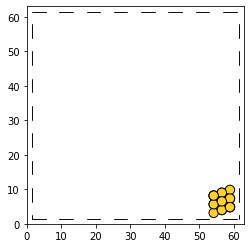

In [6]:
plot_atoms(system)

In [7]:
positions = system.get_positions()[:,:2]

# Simulate wave

In [8]:
system = Atoms(system)

In [9]:
## *** abTEM for TEM image ***
# Determine number of points for each potential slice
wave_xy = np.asarray(system.cell[0,0], system.cell[1,1])
wave_pts = int(wave_xy/sampling)

# Build potential for atoms
# Number of slices is set by atoms.cell[2,2] with a default thickness of 0.5A
potential = Potential(system,
              sampling=sampling,
              gpts=wave_pts,
              parametrization='kirkland', 
              projection='infinite')
# Build wave
wave = PlaneWave(
        energy=300e3     #acceleration voltage in eV
)
# Compute exit wave
exit_wave = wave.multislice(potential,
                         pbar=True)  

Potential:   0%|          | 0/120 [00:00<?, ?it/s]

Multislice:   0%|          | 0/120 [00:00<?, ?it/s]

In [10]:
import ase
import os
from tqdm.notebook import tqdm

dir_name = '../simulation_data/continuous_dose_series_vacuum'
if not os.path.exists(dir_name):
    for subf in ['wave', 'model', 'points']:
        os.makedirs(os.path.join(dir_name, subf))

for i in tqdm(np.arange(500)):
    # Save coordinates of positions, sites, and heights
    np.savez('{0}/points/points_{1:04d}.npz'.format(dir_name,i),
                positions=positions
            )

    # Save wavefunction in hdf5 format along (array, energy, extent)
    exit_wave.write(f'{dir_name}/wave/wave_{i:04d}')
    #wave.save('{0}/wave/wave_{1:04d}.npz'.format(dir_name,i))
    ase.io.write(f'{dir_name}/model/model_{i:04d}.cfg', system)

  0%|          | 0/500 [00:00<?, ?it/s]

# Fit MTF 

In [64]:
def fft(img):
    f = np.fft.fft2(img)
    f = np.fft.fftshift(f)

    # Set zero'th/DC component to 0.0
    c = int(f.shape[0]/2), int(f.shape[1]/2)
    f[c[0], c[1]] = 0.0

    return np.abs(f)

In [65]:
def GetPSD1D(psd2D):
    
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h,0:w]
    r    = np.hypot(X - wc, Y - hc).astype(np.int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    psd1D = ndimage.mean(psd2D, r, index=np.arange(0, wc))
    psd1D_norm = psd1D#/np.mean(psd1D)
    
    stderr = np.zeros(wc)
    for i in np.arange(wc):
        stderr[i] = ndimage.standard_deviation(psd2D, r, index=i) / np.sqrt(len(r[r==i]))  
    
    #stderr /= np.mean(psd1D)
    
    # Skip zero'th/DC component
    return psd1D_norm, r#, stderr[1:]

In [66]:
def mtf1d_fit(x, c0, c1, c2, c3):
    # 1-Dimensional MTF for fitting
    return (c1-c2)*(1/(1 + (x/c0)**c3)) + c2

In [67]:
from temnn.analysis.SimulatedAnalysis import Simulated_Data
from scipy import ndimage
from scipy.optimize import curve_fit

In [68]:
dataset = 'continuous_dose_series_vacuum'
fn = '../simulation_data/' + dataset

In [69]:
image_parameters_file = fn + '/parameters.json'
image_label_files = sorted(glob.glob(fn + '/images_labels/*.npz'))
tem_parameters_files = sorted(glob.glob(fn + '/tem_params/*'))

In [70]:
simulated_data = Simulated_Data(image_label_files[0], image_parameters_file, tem_parameters_files[0])

In [71]:
simulated_data.load()

In [72]:
simulated_data.plot()
plt.show()

In [73]:
simulated_data.dose

100.93027785534476

In [74]:
s_x = s_y = simulated_data.sampling
assert s_x == s_y

qN = 1/(2*s_x)

qx = np.fft.fftshift(np.fft.fftfreq(simulated_data.image.shape[0], d=s_x)) / qN
qy = np.fft.fftshift(np.fft.fftfreq(simulated_data.image.shape[1], d=s_y)) / qN

In [75]:
# Frequency cut off
size_in_ang = simulated_data.image.shape[0]*s_x

q_cut = 1/size_in_ang
q_half = qx[int((simulated_data.image.shape[0]/2)):]

cut_idxs = np.where(q_half >= q_cut)
q_fit = q_half[cut_idxs]

In [76]:
x = q_fit

r2 = np.zeros(len(image_label_files))
c0 = np.zeros(len(image_label_files))
c1 = np.zeros(len(image_label_files))
c2 = np.zeros(len(image_label_files))
c3 = np.zeros(len(image_label_files))
dose_list = []
for i in tqdm(np.arange(len(image_label_files))):
    simulated_data = Simulated_Data(image_label_files[i],
                                    image_parameters_file,
                                    tem_parameters_files[i])
    simulated_data.load()
    dose_list.append(simulated_data.dose)
    image = simulated_data.image[:,:,0]
    psd2d_tmp = fft(image)
    
    psd1d_tmp ,_ = GetPSD1D(psd2d_tmp)
    f_tmp = psd1d_tmp[cut_idxs]
    
    popt_tmp, _ = curve_fit(mtf1d_fit,
                        x, f_tmp,
                        bounds=((0, 0, 0, 0),(np.inf, np.inf, np.inf, np.inf))
                        )
    
    # residual sum of squares
    ss_res_fit_tmp = np.sum((f_tmp - mtf1d_fit(x,*popt_tmp)) ** 2)
    # total sum of squares
    ss_tot_fit_tmp = np.sum((f_tmp - np.mean(f_tmp)) ** 2)
    # r-squared
    r2_fit_tmp = 1 - (ss_res_fit_tmp / ss_tot_fit_tmp)

    r2[i] = r2_fit_tmp
    c0[i] = popt_tmp[0]
    c1[i] = popt_tmp[1]
    c2[i] = popt_tmp[2]
    c3[i] = popt_tmp[3]
    print('LM fit: R2 = {:.3f}, c0={:.2f}, c1={:.2f}, c2={:.2f}, c3={:.2f}'.format(r2_fit_tmp, *popt_tmp))
    print(f'c0={popt_tmp[0]:.3f}, c1={popt_tmp[3]:.3f}, C={popt_tmp[2]/popt_tmp[1]:.3f}')

  0%|          | 0/500 [00:00<?, ?it/s]

LM fit: R2 = 0.988, c0=0.27, c1=329.18, c2=41.48, c3=2.40
c0=0.270, c1=2.400, C=0.126
LM fit: R2 = 0.993, c0=0.26, c1=595.12, c2=20.84, c3=2.16
c0=0.263, c1=2.161, C=0.035
LM fit: R2 = 0.989, c0=0.23, c1=575.62, c2=36.02, c3=2.54
c0=0.234, c1=2.537, C=0.063
LM fit: R2 = 0.973, c0=0.21, c1=124.29, c2=53.44, c3=3.48
c0=0.212, c1=3.476, C=0.430
LM fit: R2 = 0.988, c0=0.21, c1=191.90, c2=48.84, c3=3.39
c0=0.208, c1=3.386, C=0.254
LM fit: R2 = 0.993, c0=0.21, c1=354.27, c2=26.74, c3=2.45
c0=0.212, c1=2.451, C=0.075
LM fit: R2 = 0.993, c0=0.25, c1=295.58, c2=44.34, c3=3.29
c0=0.248, c1=3.294, C=0.150
LM fit: R2 = 0.991, c0=0.23, c1=208.30, c2=51.70, c3=3.46
c0=0.230, c1=3.463, C=0.248
LM fit: R2 = 0.994, c0=0.21, c1=889.61, c2=44.42, c3=3.14
c0=0.211, c1=3.141, C=0.050
LM fit: R2 = 0.992, c0=0.25, c1=505.50, c2=30.47, c3=2.41
c0=0.249, c1=2.414, C=0.060
LM fit: R2 = 0.991, c0=0.24, c1=243.41, c2=32.34, c3=2.24
c0=0.244, c1=2.242, C=0.133
LM fit: R2 = 0.988, c0=0.23, c1=189.85, c2=37.61, c3=2

LM fit: R2 = 0.993, c0=0.26, c1=317.55, c2=37.30, c3=3.46
c0=0.263, c1=3.463, C=0.117
LM fit: R2 = 0.992, c0=0.25, c1=564.31, c2=30.26, c3=2.70
c0=0.253, c1=2.704, C=0.054
LM fit: R2 = 0.991, c0=0.20, c1=289.11, c2=42.37, c3=2.34
c0=0.199, c1=2.337, C=0.147
LM fit: R2 = 0.993, c0=0.26, c1=395.65, c2=37.06, c3=2.38
c0=0.262, c1=2.383, C=0.094
LM fit: R2 = 0.987, c0=0.23, c1=259.33, c2=48.51, c3=3.25
c0=0.225, c1=3.249, C=0.187
LM fit: R2 = 0.990, c0=0.25, c1=239.16, c2=47.78, c3=2.97
c0=0.246, c1=2.974, C=0.200
LM fit: R2 = 0.995, c0=0.24, c1=360.34, c2=43.41, c3=3.09
c0=0.244, c1=3.088, C=0.120
LM fit: R2 = 0.992, c0=0.21, c1=455.48, c2=37.82, c3=2.77
c0=0.210, c1=2.773, C=0.083
LM fit: R2 = 0.990, c0=0.27, c1=249.92, c2=22.41, c3=2.08
c0=0.267, c1=2.085, C=0.090
LM fit: R2 = 0.989, c0=0.18, c1=246.00, c2=53.31, c3=2.88
c0=0.181, c1=2.877, C=0.217
LM fit: R2 = 0.991, c0=0.26, c1=279.20, c2=32.05, c3=2.54
c0=0.255, c1=2.538, C=0.115
LM fit: R2 = 0.994, c0=0.20, c1=958.20, c2=16.98, c3=2

LM fit: R2 = 0.995, c0=0.23, c1=567.09, c2=25.50, c3=2.72
c0=0.234, c1=2.720, C=0.045
LM fit: R2 = 0.992, c0=0.20, c1=428.97, c2=35.32, c3=2.30
c0=0.203, c1=2.305, C=0.082
LM fit: R2 = 0.993, c0=0.22, c1=548.28, c2=42.29, c3=2.84
c0=0.223, c1=2.842, C=0.077
LM fit: R2 = 0.989, c0=0.25, c1=202.65, c2=39.02, c3=2.71
c0=0.252, c1=2.714, C=0.193
LM fit: R2 = 0.993, c0=0.27, c1=458.90, c2=25.81, c3=2.44
c0=0.265, c1=2.436, C=0.056
LM fit: R2 = 0.988, c0=0.24, c1=175.71, c2=46.95, c3=3.43
c0=0.238, c1=3.429, C=0.267
LM fit: R2 = 0.980, c0=0.17, c1=140.07, c2=47.15, c3=3.27
c0=0.174, c1=3.269, C=0.337
LM fit: R2 = 0.994, c0=0.25, c1=422.44, c2=28.82, c3=3.15
c0=0.250, c1=3.150, C=0.068
LM fit: R2 = 0.988, c0=0.21, c1=139.10, c2=53.71, c3=3.69
c0=0.207, c1=3.687, C=0.386
LM fit: R2 = 0.984, c0=0.17, c1=171.58, c2=33.07, c3=2.57
c0=0.175, c1=2.566, C=0.193
LM fit: R2 = 0.991, c0=0.20, c1=290.47, c2=44.31, c3=2.59
c0=0.197, c1=2.588, C=0.153
LM fit: R2 = 0.993, c0=0.25, c1=437.66, c2=46.86, c3=2

LM fit: R2 = 0.984, c0=0.24, c1=171.45, c2=52.46, c3=3.12
c0=0.241, c1=3.119, C=0.306
LM fit: R2 = 0.994, c0=0.26, c1=592.22, c2=35.48, c3=2.42
c0=0.261, c1=2.421, C=0.060
LM fit: R2 = 0.991, c0=0.22, c1=1030.81, c2=18.37, c3=2.20
c0=0.224, c1=2.200, C=0.018
LM fit: R2 = 0.993, c0=0.29, c1=951.87, c2=6.21, c3=2.27
c0=0.287, c1=2.265, C=0.007
LM fit: R2 = 0.992, c0=0.23, c1=254.94, c2=43.66, c3=2.85
c0=0.232, c1=2.855, C=0.171
LM fit: R2 = 0.993, c0=0.23, c1=949.18, c2=18.63, c3=2.25
c0=0.233, c1=2.255, C=0.020
LM fit: R2 = 0.976, c0=0.21, c1=134.17, c2=50.81, c3=3.64
c0=0.212, c1=3.638, C=0.379
LM fit: R2 = 0.994, c0=0.28, c1=984.19, c2=24.24, c3=2.64
c0=0.282, c1=2.642, C=0.025
LM fit: R2 = 0.991, c0=0.29, c1=662.85, c2=36.01, c3=3.01
c0=0.289, c1=3.009, C=0.054
LM fit: R2 = 0.988, c0=0.23, c1=252.95, c2=45.77, c3=2.59
c0=0.231, c1=2.590, C=0.181
LM fit: R2 = 0.978, c0=0.18, c1=137.37, c2=45.28, c3=3.75
c0=0.180, c1=3.750, C=0.330
LM fit: R2 = 0.993, c0=0.25, c1=349.64, c2=27.57, c3=2

LM fit: R2 = 0.992, c0=0.22, c1=545.61, c2=46.46, c3=3.11
c0=0.221, c1=3.106, C=0.085
LM fit: R2 = 0.986, c0=0.24, c1=131.75, c2=43.33, c3=3.60
c0=0.236, c1=3.598, C=0.329
LM fit: R2 = 0.991, c0=0.22, c1=953.91, c2=45.85, c3=3.01
c0=0.219, c1=3.011, C=0.048
LM fit: R2 = 0.993, c0=0.25, c1=329.64, c2=43.30, c3=2.26
c0=0.252, c1=2.258, C=0.131
LM fit: R2 = 0.992, c0=0.22, c1=289.90, c2=32.43, c3=3.14
c0=0.216, c1=3.142, C=0.112
LM fit: R2 = 0.992, c0=0.22, c1=625.53, c2=26.99, c3=2.42
c0=0.224, c1=2.423, C=0.043
LM fit: R2 = 0.991, c0=0.21, c1=319.98, c2=36.32, c3=3.18
c0=0.211, c1=3.180, C=0.114
LM fit: R2 = 0.990, c0=0.18, c1=179.30, c2=49.01, c3=3.51
c0=0.178, c1=3.511, C=0.273
LM fit: R2 = 0.991, c0=0.22, c1=186.26, c2=40.16, c3=2.77
c0=0.223, c1=2.774, C=0.216
LM fit: R2 = 0.992, c0=0.23, c1=297.96, c2=47.93, c3=2.76
c0=0.225, c1=2.759, C=0.161
LM fit: R2 = 0.991, c0=0.19, c1=175.38, c2=38.38, c3=2.53
c0=0.195, c1=2.528, C=0.219
LM fit: R2 = 0.993, c0=0.21, c1=149.88, c2=33.55, c3=2

LM fit: R2 = 0.984, c0=0.21, c1=159.25, c2=36.93, c3=3.31
c0=0.207, c1=3.307, C=0.232
LM fit: R2 = 0.980, c0=0.21, c1=125.28, c2=46.29, c3=2.58
c0=0.210, c1=2.576, C=0.369
LM fit: R2 = 0.994, c0=0.23, c1=863.34, c2=25.61, c3=2.84
c0=0.230, c1=2.837, C=0.030
LM fit: R2 = 0.994, c0=0.26, c1=881.73, c2=25.03, c3=3.05
c0=0.264, c1=3.051, C=0.028
LM fit: R2 = 0.993, c0=0.21, c1=480.51, c2=32.49, c3=3.18
c0=0.209, c1=3.180, C=0.068
LM fit: R2 = 0.992, c0=0.26, c1=688.23, c2=39.74, c3=2.96
c0=0.258, c1=2.958, C=0.058
LM fit: R2 = 0.993, c0=0.28, c1=714.27, c2=32.50, c3=2.68
c0=0.275, c1=2.684, C=0.046
LM fit: R2 = 0.989, c0=0.25, c1=135.16, c2=47.66, c3=3.42
c0=0.249, c1=3.420, C=0.353
LM fit: R2 = 0.990, c0=0.24, c1=179.03, c2=30.76, c3=2.61
c0=0.238, c1=2.613, C=0.172
LM fit: R2 = 0.982, c0=0.19, c1=179.38, c2=51.63, c3=2.55
c0=0.195, c1=2.549, C=0.288
LM fit: R2 = 0.992, c0=0.21, c1=771.69, c2=46.97, c3=3.42
c0=0.209, c1=3.425, C=0.061
LM fit: R2 = 0.992, c0=0.26, c1=787.75, c2=38.48, c3=2

In [77]:
idxs = np.where(r2 >= 0.95)

dose_good = np.asarray(dose_list)[idxs]
r2_good = r2[idxs]
c0_good = c0[idxs]
c1_good = c1[idxs]
c2_good = c2[idxs]
c3_good = c3[idxs]

In [78]:
C = c2/c1
C_good = C[idxs]

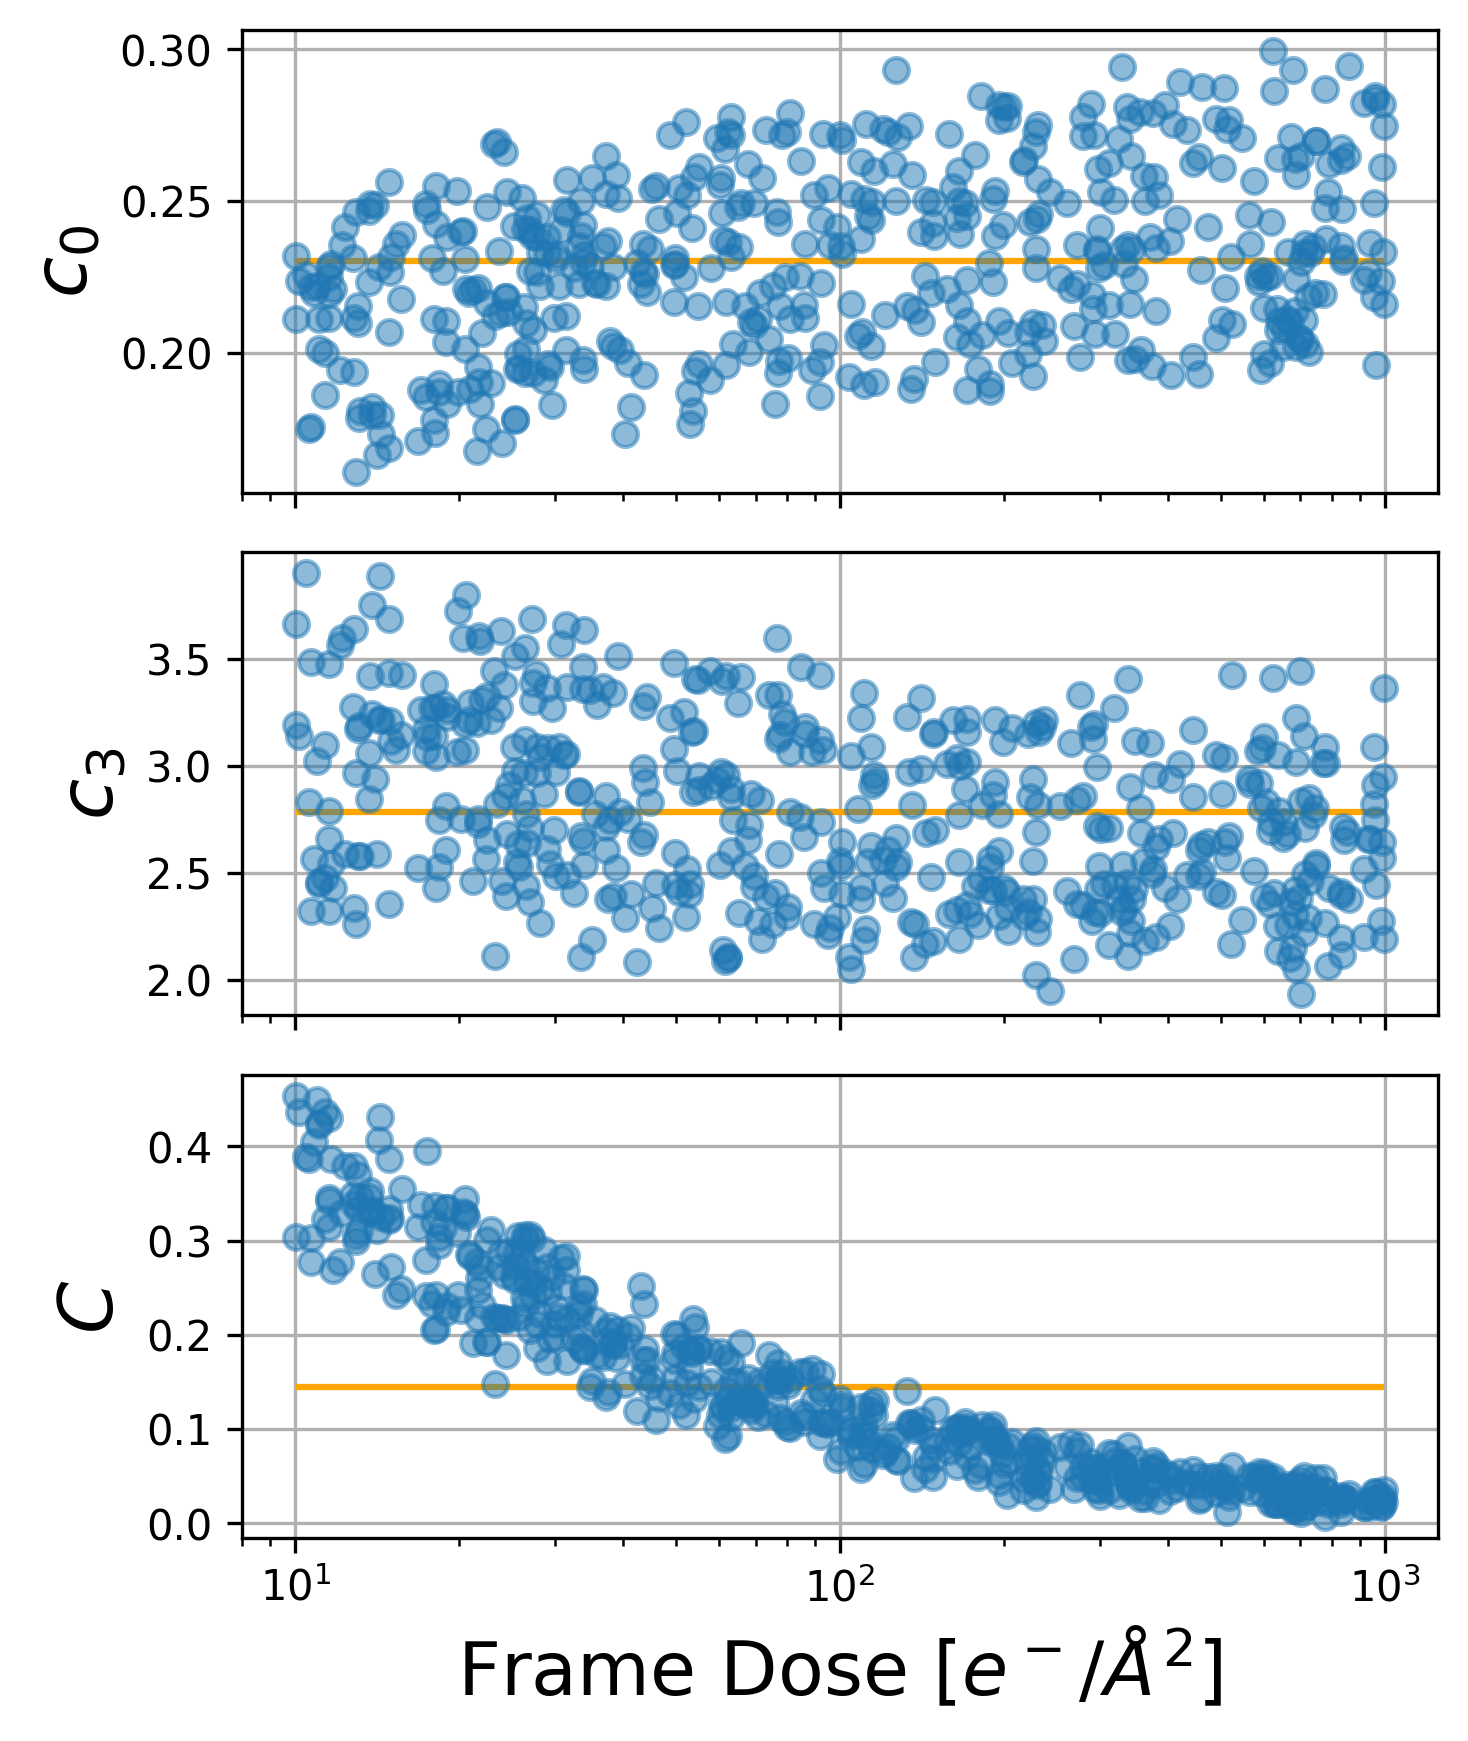

In [80]:
from matplotlib.ticker import NullFormatter
dose = dose_list

fig, axs = plt.subplots(3,1,figsize=(5,6))

axs[0].plot(dose_good, c0_good, 'o', alpha=0.5)
axs[0].hlines(xmin=np.min(dose), xmax=np.max(dose), y=np.mean(c0_good), color='orange')

axs[1].plot(dose_good, c3_good, 'o', alpha=0.5)
axs[1].hlines(xmin=np.min(dose), xmax=np.max(dose), y=np.mean(c3_good), color='orange')

axs[2].plot(dose_good, C_good, 'o', alpha=0.5)
axs[2].hlines(xmin=np.min(dose), xmax=np.max(dose), y=np.mean(C_good), color='orange')

axs[0].set_ylabel('$c_0$',fontsize=18)
axs[1].set_ylabel('$c_3$',fontsize=18)
axs[2].set_ylabel('$C$',fontsize=18)

axs[2].set_xlabel('Frame Dose [$e^-$/$Å^2$]',fontsize=18)

axs[0].grid()
axs[1].grid()
axs[2].grid()

for ax in axs:
    ax.set_xscale('log')
axs[0].xaxis.set_major_formatter(NullFormatter())
axs[0].xaxis.set_minor_formatter(NullFormatter())
axs[1].xaxis.set_major_formatter(NullFormatter())
axs[1].xaxis.set_minor_formatter(NullFormatter())

plt.tight_layout()
plt.gcf().set_dpi(300)
#plt.savefig('MTFParameter_DoseDependence_Simulated.png')
plt.show()